<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float:  left; margin: 10px;">

# Bias-Variance-Train-Test-Split-Lab
---
Week 4 | Lab 1.1

# Bias-variance lab

In this lab you'll explore how bias and variance changes using a dataset on college statistics.

---

In [26]:
import numpy as np
import scipy 
import seaborn as sns
import pandas as pd
import patsy

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.cross_validation import cross_val_score, KFold, train_test_split

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

---

### Load data

Feel free to choose a target variable on your own. I chose "Grad.Rate" as my target variable but it's not required.

You'll want to discard the name of the college, and if you're planning on using the "Private" variable it will have to be changed into 1s and 0s rather than yes/no.

In [27]:
college = pd.read_csv('~/DSI-SF-5/datasets/college_stats/College.csv')

In [28]:
college.dtypes

Unnamed: 0      object
Private         object
Apps             int64
Accept           int64
Enroll           int64
Top10perc        int64
Top25perc        int64
F.Undergrad      int64
P.Undergrad      int64
Outstate         int64
Room.Board       int64
Books            int64
Personal         int64
PhD              int64
Terminal         int64
S.F.Ratio      float64
perc.alumni      int64
Expend           int64
Grad.Rate        int64
dtype: object

In [29]:
college.rename(columns={'Unnamed: 0':'College'}, inplace=True)

In [30]:
college.head(3)

,College,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54


In [31]:
gradrate = college['Grad.Rate'].values
X = college.iloc[:,1:-1]

In [32]:
X.head(2)

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527


In [33]:
X.Private = X.Private.map(lambda x: 1 if x == 'Yes' else 0)

In [34]:
X.columns = [x.lower().replace('.','_') for x in X.columns]

In [35]:
X.head(2)

,private,apps,accept,enroll,top10perc,top25perc,f_undergrad,p_undergrad,outstate,room_board,books,personal,phd,terminal,s_f_ratio,perc_alumni,expend
0,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041
1,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527


In [36]:
featurenames = X.columns

---

### Cross-validate a linear regression predicting your target variable from the other variables

Use Sklearn's implementation of [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) which will cross validate and score your model for you. 

Use 'neg_mean_squared_error' as your scoring method. This will cross_val_score will return the negative of the mean square error. In order to analyze the mean square error, simply multiply 'neg_mean_squared_error' by negative one.

How does it perform?

In [55]:
linreg = LinearRegression()

lr_scores = cross_val_score(linreg, X, gradrate, cv=10, scoring = 'neg_mean_squared_error')

linreg.fit(X, gradrate)

print -1*lr_scores, -1*np.mean(lr_scores)

[ 156.61047196  199.5371563   140.97878176  173.39589458  222.40486258
  172.86023644  188.79545328  163.46099385  106.78761673  178.37002974] 170.320149723


In [43]:
for f, c in zip(featurenames, linreg.coef_):
    print f, c

private 3.38137582338
apps 0.00129841619653
accept -0.000696123912254
enroll 0.00215927836564
top10perc 0.0548964393801
top25perc 0.13512882248
f_undergrad -0.000471221055472
p_undergrad -0.00148364257626
outstate 0.00101744533787
room_board 0.001914341067
books -0.00222046570937
personal -0.00166353476834
phd 0.0872827138864
terminal -0.07470226732
s_f_ratio 0.0758222052443
perc_alumni 0.279334292031
expend -0.000456463007097


---

### Create a function that will iteratively predict your target from different train-test splits

This will be used to calculate the bias and the variance after this.

Your function should:

1. Accept a model, X predictor matrix/dataframe, y target variable, and a number of random splits to do training and testing on.
2. The output should be a dataframe that has as its first column the true values of y, and all the other columns will be corresponding predicted values of y when that row was in the testing set.
3. It will iterate through the number of splits
4. Create a variable that is the list of row numbers. Use this with `train_test_split` to get out randomized training rows and testing rows for each iteration.
5. Subset your X and y into training and testing
6. Train your model on the training X and training y
7. Predict values of y using the testing X
8. Add the predicted values of y to the dataframe tracking y predictions - the predicted y values should be insert in the correct row so that they match the true value of y in the first column. You can index using the test indices you got out of train_test_split to do this. (The rest of the rows that were part of the training set can be nan for that iteration).


**NOTE: ** This function will look considerably different than the "cross_validate" function that I wrote in the test-train-split lesson. 

In [44]:
def predict_from_samples(model, X, y, number_of_splits=100):
    
    yhat_tracker = pd.DataFrame({'ytrue':y})
    
    rowinds = range(X.shape[0])
    
    for i in range(number_of_splits):
        
        train_inds, test_inds = train_test_split(rowinds, test_size=0.33)
                
        Xtrain, Ytrain = X.iloc[train_inds, :], y[train_inds]
        Xtest, Ytest = X.iloc[test_inds, :],    y[test_inds]
        
        model.fit(Xtrain, Ytrain)
        yhats = model.predict(Xtest)
        
        yhat_tracker['sample'+str(i+1)] = np.nan
        yhat_tracker.iloc[test_inds, -1] = yhats
        
    return yhat_tracker

---

### Create different predictor datasets

To see what happens to bias and variance as the predictors change, create a few versions of X that have different numbers of predictors in them.

For example, one could have all the other variables, and another one could be predicting only using private vs. public.

In [56]:
# get every combination of 3 features (i.e. n Choose k ) 
# and add them together to create a new feature than add it to X
overfit_formula = '~ ('+' + '.join(featurenames)+')**3 -1'
X_overfit = patsy.dmatrix(overfit_formula, data=X, return_type='dataframe')

# only look at whether the school is public or private
X_small = X[['private']]

In [72]:
X_overfit.head()

,private,apps,accept,enroll,top10perc,top25perc,f_undergrad,p_undergrad,outstate,room_board,...,phd:terminal:s_f_ratio,phd:terminal:perc_alumni,phd:terminal:expend,phd:s_f_ratio:perc_alumni,phd:s_f_ratio:expend,phd:perc_alumni:expend,terminal:s_f_ratio:perc_alumni,terminal:s_f_ratio:expend,terminal:perc_alumni:expend,s_f_ratio:perc_alumni:expend
0,1.0,1660.0,1232.0,721.0,23.0,52.0,2885.0,537.0,7440.0,3300.0,...,98826.0,65520.0,38443860.0,15204.0,8920947.0,5914440.0,16941.6,9940483.8,6590376.0,1529305.2
1,1.0,2186.0,1924.0,512.0,16.0,29.0,2683.0,1227.0,12280.0,6450.0,...,10614.0,13920.0,9158490.0,5660.8,3724452.6,4884528.0,5856.0,3852882.0,5052960.0,2054870.4
2,1.0,1428.0,1097.0,336.0,22.0,50.0,1036.0,99.0,11250.0,3750.0,...,45124.2,104940.0,30555030.0,20511.0,5972119.5,13888650.0,25542.0,7436979.0,17295300.0,3380445.0
3,1.0,417.0,349.0,137.0,60.0,89.0,510.0,63.0,12960.0,5450.0,...,68714.8,330188.0,169698784.0,26210.8,13470934.4,64730464.0,27635.3,14203050.4,68248424.0,5417658.4
4,1.0,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,4120.0,...,65116.8,10944.0,59765184.0,1808.8,9877856.8,1660144.0,1713.6,9357969.6,1572768.0,259943.6


---

### Use the predict function you wrote above to get the predicted values for each version of the data

Run each of your X through the function with the y target vector. As you recall the output of your function has the true values of y in a column and then predicted values of y in other columns for the different train-test splits

In [57]:
yhats_full = predict_from_samples(linreg, X, gradrate)
yhats_small = predict_from_samples(linreg, X_small, gradrate)
yhats_over = predict_from_samples(linreg, X_overfit, gradrate)

print X.shape, X_small.shape, X_overfit.shape
print yhats_full.shape, yhats_small.shape, yhats_over.shape

(777, 17) (777, 1) (777, 833)
(777, 101) (777, 101) (777, 101)


In [58]:
yhats_full.head(5)

,ytrue,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,...,sample91,sample92,sample93,sample94,sample95,sample96,sample97,sample98,sample99,sample100
0,60,53.731563,NaN,NaN,55.971737,NaN,56.732874,NaN,NaN,NaN,...,NaN,NaN,NaN,55.643294,NaN,55.916540,NaN,NaN,59.790594,NaN
1,56,67.639891,64.813772,NaN,65.098489,62.157157,NaN,NaN,63.215912,63.916046,...,64.927190,62.846937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,54,NaN,NaN,NaN,NaN,NaN,67.541697,NaN,NaN,NaN,...,NaN,NaN,67.584771,NaN,NaN,NaN,NaN,NaN,67.270221,NaN
3,59,NaN,NaN,NaN,NaN,NaN,78.132323,NaN,NaN,76.978325,...,NaN,77.208827,NaN,NaN,NaN,77.612767,NaN,NaN,74.549321,77.890467
4,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.810827,NaN,...,53.172176,52.303726,NaN,52.480635,53.193393,51.783628,NaN,NaN,NaN,53.653503


---

### Calculate bias and variance 

I've given you two functions below to calculate bias and variance if they are given the dataframe that has the first column as the true y values and the other column the predicted y values at each train/test split iteration.

You can use these to calculate the bias and variance of your different predictor variables. If you have more predictors variance of prediction should generally go up and bias goes down. Likewise, if you have few predictors variance should go down and bias goes up.

If you have an insanely bad model, they both might go up a lot!

In [59]:
def calculate_bias_sq(yhats_df):
    # Take out the true values of y that are in the first column:
    ytrue = yhats_df.iloc[:,0].values
    
    # Calculate the mean of the predictions, averaged across the columns.
    # So, all of the predictions for the true y at row 0 would be averaged together
    # and so on for all the rows.
    yhat_means = yhats_df.iloc[:,1:].mean(axis=1).values
    
    # Subtract the true value of y from the mean of the predicted values, and square it.
    elementwise_bias_sq = (yhat_means - ytrue)**2
    
    # Take the mean of those squared bias values (across all y)
    mean_bias_sq = np.mean(elementwise_bias_sq)
    return mean_bias_sq


def calculate_variance(yhats_df):
    # Calculate the mean of the predicted y's across the columns (mean of yhat for each row)
    yhats_means = yhats_df.iloc[:,1:].mean(axis=1)
    
    # subtract the mean of the yhats from the original yhat values (for each row)
    # and square the result. 
    yhats_devsq = yhats_df.iloc[:,1:].subtract(yhats_means, axis=0)**2
    
    # Take the mean of the squared deviations from the mean, then 
    # take the mean of those to get the overall variance across the y observations
    yhats_devsq_means = yhats_devsq.mean(axis=1).values
    return np.mean(yhats_devsq_means)


In [67]:
print calculate_bias_sq(yhats_full), calculate_variance(yhats_full)

168.785907505 2.5479186244


In [69]:
print calculate_bias_sq(yhats_small), calculate_variance(yhats_small)

262.732308859 0.3196221652


In [70]:
print calculate_bias_sq(yhats_over), calculate_variance(yhats_over)

175528.668155 4874268.55387


## Learning Curves

Plot a learning curve for each of your 3 different predictors  (ie. you should have created 3 different design matricies X, each with a different sete of predictors).

Use Sklearn's built-in learning curves funciton: [learning_curve](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve)   **Yes, you should read the docs.** 

Sklearn's learning_curve will do two things for you:

1. It will cross validate your model for you
2. It will return: train_sizes_abs, train_scores, and test_scores which you can use to plot a learning curve


For each of your 3 design matricies: 

1. Use learning_curve with these parameters:  

        train_sizes=np.arange(0.1, 1.1, 0.1), 
        scoring = 'neg_mean_squared_error',
        cv=10, 
        n_jobs=3
        
        Make sure you understand what each of these parameters are doing!
    
2. Take the sum of your train_errors and test_errors along their columns. **Explain why this makes sense!** Hint: you specified 10 CV iterations, and 10 train_size which will iterate through the training sizes for each CV instance. So you'll recieve a 10x10 matrix for each error vector from learning_curve.

3. Multiply your results train_errors and test_errors from part 2 by negative one. 

4. Plot your learning curve and label your plot

5. Make some observations about how well your model performs (i.e. underfitting, overfitting, overtraining, ...) Do the bias/variance calculates you made above provide any insight about your learning curves?

In [74]:
from sklearn.model_selection import learning_curve

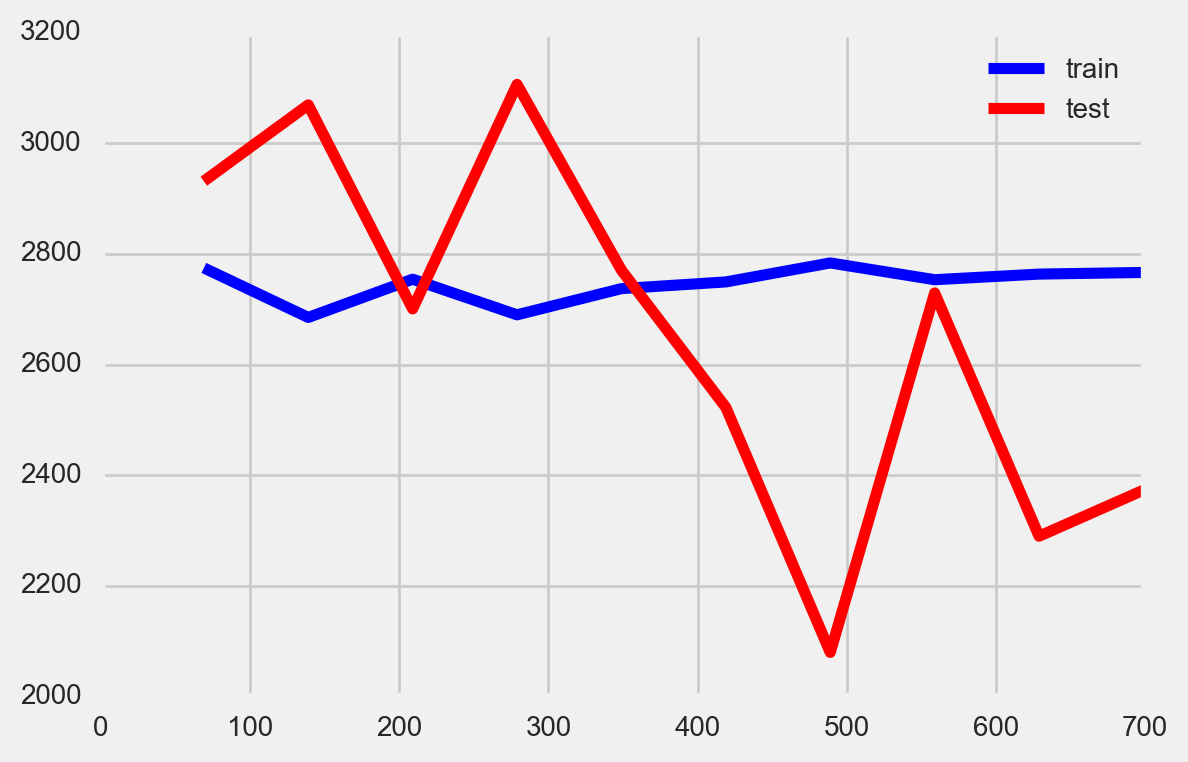

In [147]:
train_size, train_errors, test_errors = \
learning_curve(LinearRegression(),X_small, gradrate, train_sizes=np.arange(0.1, 1.1, 0.1),
               scoring = 'neg_mean_squared_error',cv=10, n_jobs=3)

train_e = -1*np.sum(train_errors, axis = 0)
test_e = -1*np.sum(test_errors, axis = 0)

plt.plot(train_size, train_e, 'b', label = 'train');
plt.plot(train_size, test_e, 'r', label = 'test');
plt.legend();

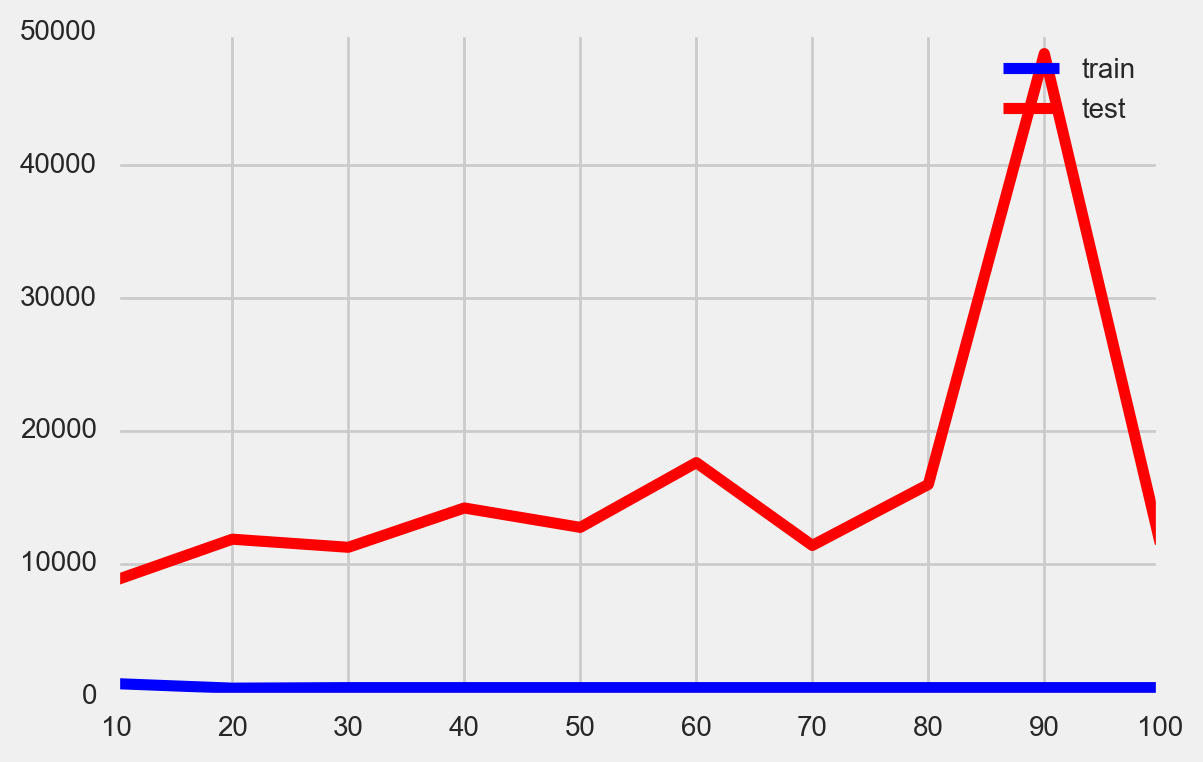

In [148]:
train_size, train_errors, test_errors = \
learning_curve(LinearRegression(),X, gradrate, train_sizes=np.arange(10,110,10),
               scoring = 'neg_mean_squared_error',cv=10, n_jobs=3)

train_e = -1*np.sum(train_errors, axis = 0)
test_e = -1*np.sum(test_errors, axis = 0)

plt.plot(train_size, train_e, 'b', label = 'train');
plt.plot(train_size, test_e, 'r', label = 'test');
plt.legend();

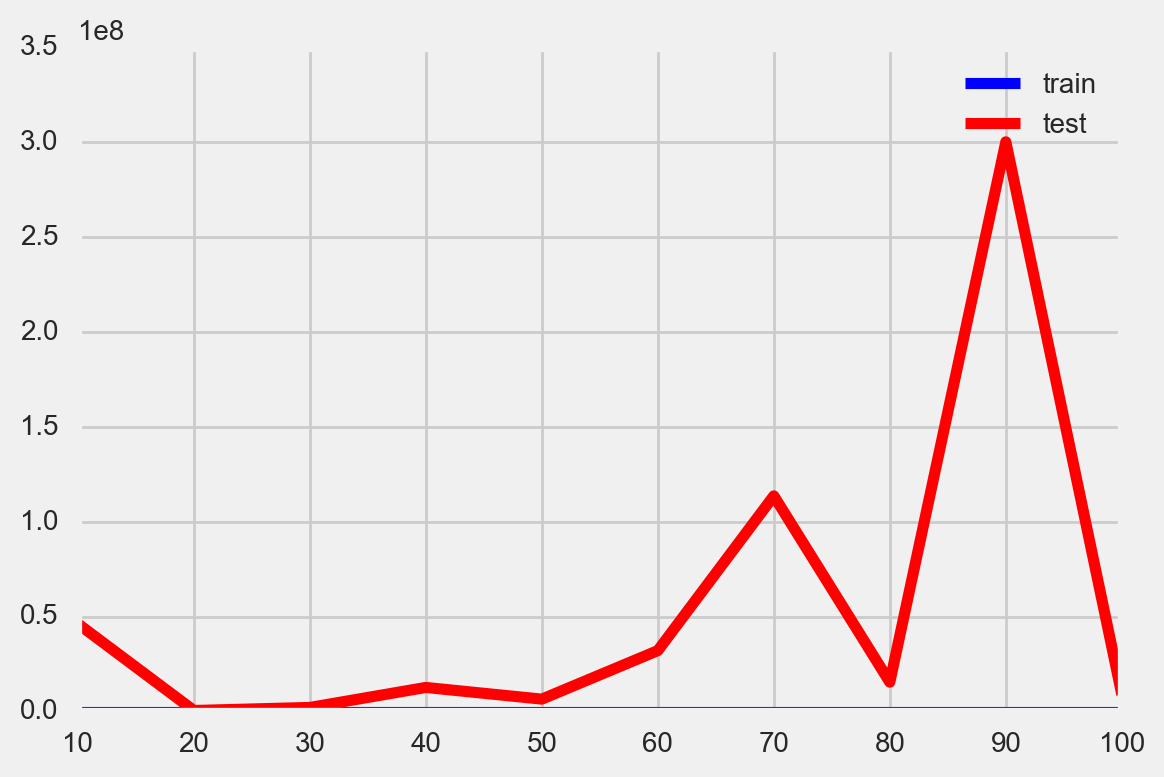

In [149]:
train_size, train_errors, test_errors = \
learning_curve(LinearRegression(),X_overfit, gradrate, train_sizes=np.arange(10,110,10),
               scoring = 'neg_mean_squared_error',cv=10, n_jobs=3)

train_e = -1*np.sum(train_errors, axis = 0)
test_e = -1*np.sum(test_errors, axis = 0)

plt.plot(train_size, train_e, 'b', label = 'train');
plt.plot(train_size, test_e, 'r', label = 'test');
plt.legend();